##### © Copyright 2020 [George Mihaila](https://github.com/gmihaila).

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Install transformers library.
!pip install -q git+https://github.com/huggingface/transformers.git
# Install helper functions.
!pip install -q git+https://github.com/gmihaila/ml_things.git

## **Imports**

Import all needed libraries for this notebook.

Declare parameters used for this notebook:

* `set_seed(123)` - Always good to set a fixed seed for reproducibility.
* `epochs` - Number of training epochs (authors recommend between 2 and 4).
* `batch_size` - Number of batches - depending on the max sequence length and GPU memory. For 512 sequence length a batch of 10 USUALY works without cuda memory issues. For small sequence length can try batch of 32 or higher.
max_length - Pad or truncate text sequences to a specific length. I will set it to 60 to speed up training.
* `device` - Look for gpu to use. Will use cpu by default if no gpu found.
* `model_name_or_path` - Name of transformers model - will use already pretrained model. Path of transformer model - will load your own model from local disk. In this tutorial I will use `gpt2` model.
* `labels_ids` - Dictionary of labels and their id - this will be used to convert string labels to numbers.
* `n_labels` - How many labels are we using in this dataset. This is used to decide size of classification head.

In [2]:
import io
import os
import torch
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from ml_things import plot_dict, plot_confusion_matrix, fix_text
from sklearn.metrics import classification_report, accuracy_score
from transformers import (set_seed,
                          TrainingArguments,
                          Trainer,
                          GPT2Config,
                          GPT2Tokenizer,
                          AdamW, 
                          get_linear_schedule_with_warmup,
                          GPT2ForSequenceClassification)

# Set seed for reproducibility.
set_seed(123)

# Number of training epochs (authors on fine-tuning Bert recommend between 2 and 4).
epochs = 4

# Number of batches - depending on the max sequence length and GPU memory.
# For 512 sequence length batch of 10 works without cuda memory issues.
# For small sequence length can try batch of 32 or higher.
batch_size = 16

# Pad or truncate text sequences to a specific length
# if `None` it will use maximum sequence of word piece tokens allowed by model.
max_length = 128

# Look for gpu to use. Will use `cpu` by default if no gpu found.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Name of transformers model - will use already pretrained model.
# Path of transformer model - will load your own model from local disk.
model_name_or_path = 'gpt2'

# Dictionary of labels and their id - this will be used to convert.
# String labels to number ids.
labels_ids = {'R': 0, 'D': 1}

# How many labels are we using in training.
# This is used to decide size of classification head.
n_labels = len(labels_ids)

print(device)

cuda


In [23]:
import pandas as pd
import glob

df = pd.DataFrame()
files = ['../data/processed/hein-daily-114.csv'] # , '../data/processed/hein-daily-113.csv'
for f in files:
    csv = pd.read_csv(f)
    df = df.append(csv)
print(df)

row = df.iloc[1]
print(f'{row[1]}_{row[3]}_{row[2]}_{row[4]}_{row[5]}')

                                                  speech party  \
0      RODGERS it is an honor to address the House at...     R   
1      First I would like to recognize each and every...     D   
2      I present for election to the office of Speake...     R   
3      I present for the election of the office of Sp...     R   
4      I rise to place in a nomination for election t...     R   
...                                                  ...   ...   
45450  This year marks the 50th anniversary of the Sh...     R   
45451  I rise today to congratulate the men and women...     R   
45452  I rise today because this week is National Sui...     R   
45453  It has been 2 years since the people of Flint ...     D   
45454  The University of Southern Indianas College of...     R   

               lastname firstname state  speakerid  
0      MCMORRIS RODGERS     CATHY    WA     120480  
1               BECERRA    XAVIER    CA     118560  
2                MASSIE    THOMAS    KY     1218

/tmp/ipykernel_119269/658441279.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(csv)


In [24]:
from torch.utils.data import Dataset
import pandas as pd
import glob

class MovieReviewsDataset(Dataset):
  r"""PyTorch Dataset class for loading data.

  This is where the data parsing happens.

  This class is built with reusability in mind: it can be used as is as.

  Arguments:

    path (:obj:`str`):
        Path to the data partition.

  """

  def __init__(self, path, use_tokenizer):
    self.df = pd.DataFrame()
    files = ['../data/processed/hein-daily-114.csv'] # , '../data/processed/hein-daily-113.csv'
    for f in files:
      csv = pd.read_csv(f)
      self.df = self.df.append(csv)

  def __len__(self):
    r"""When used `len` return the number of examples.

    """
    
    return len(self.df)

  def __getitem__(self, item):
    r"""Given an index return an example from the position.
    
    Arguments:

      item (:obj:`int`):
          Index position to pick an example to return.

    Returns:
      :obj:`Dict[str, str]`: Dictionary of inputs that contain text and 
      asociated labels.

    """
    row = self.df.iloc[item]

    return {'text':row[0],
            'label':row[1],
            'speaker':f'{row[1]}_{row[3]}_{row[2]}_{row[4]}_{row[5]}'}



class Gpt2ClassificationCollator(object):
    r"""
    Data Collator used for GPT2 in a classificaiton rask. 
    
    It uses a given tokenizer and label encoder to convert any text and labels to numbers that 
    can go straight into a GPT2 model.

    This class is built with reusability in mind: it can be used as is as long
    as the `dataloader` outputs a batch in dictionary format that can be passed 
    straight into the model - `model(**batch)`.

    Arguments:

      use_tokenizer (:obj:`transformers.tokenization_?`):
          Transformer type tokenizer used to process raw text into numbers.

      labels_ids (:obj:`dict`):
          Dictionary to encode any labels names into numbers. Keys map to 
          labels names and Values map to number associated to those labels.

      max_sequence_len (:obj:`int`, `optional`)
          Value to indicate the maximum desired sequence to truncate or pad text
          sequences. If no value is passed it will used maximum sequence size
          supported by the tokenizer and model.

    """

    def __init__(self, use_tokenizer, labels_encoder, max_sequence_len=None):

        # Tokenizer to be used inside the class.
        self.use_tokenizer = use_tokenizer
        # Check max sequence length.
        self.max_sequence_len = use_tokenizer.model_max_length if max_sequence_len is None else max_sequence_len
        # Label encoder used inside the class.
        self.labels_encoder = labels_encoder

        return

    def __call__(self, sequences):
        r"""
        This function allowes the class objesct to be used as a function call.
        Sine the PyTorch DataLoader needs a collator function, I can use this 
        class as a function.

        Arguments:

          item (:obj:`list`):
              List of texts and labels.

        Returns:
          :obj:`Dict[str, object]`: Dictionary of inputs that feed into the model.
          It holddes the statement `model(**Returned Dictionary)`.
        """

        # Get all texts from sequences list.
        texts = [sequence['text'] for sequence in sequences]
        # Get all labels from sequences list.
        labels = [sequence['label'] for sequence in sequences]
        # Encode all labels using label encoder.
        labels = [self.labels_encoder[label] for label in labels]
        # Call tokenizer on all texts to convert into tensors of numbers with 
        # appropriate padding.
        inputs = self.use_tokenizer(text=texts, return_tensors="pt", padding=True, truncation=True,  max_length=self.max_sequence_len)
        # Update the inputs with the associated encoded labels as tensor.
        inputs.update({'labels':torch.tensor(labels)})
        inputs.update({'speakers':[sequence['speaker'] for sequence in sequences]})

        return inputs


def train(dataloader, optimizer_, scheduler_, device_):
  r"""
  Train pytorch model on a single pass through the data loader.

  It will use the global variable `model` which is the transformer model 
  loaded on `_device` that we want to train on.

  This function is built with reusability in mind: it can be used as is as long
    as the `dataloader` outputs a batch in dictionary format that can be passed 
    straight into the model - `model(**batch)`.

  Arguments:

      dataloader (:obj:`torch.utils.data.dataloader.DataLoader`):
          Parsed data into batches of tensors.

      optimizer_ (:obj:`transformers.optimization.AdamW`):
          Optimizer used for training.

      scheduler_ (:obj:`torch.optim.lr_scheduler.LambdaLR`):
          PyTorch scheduler.

      device_ (:obj:`torch.device`):
          Device used to load tensors before feeding to model.

  Returns:

      :obj:`List[List[int], List[int], float]`: List of [True Labels, Predicted
        Labels, Train Average Loss].
  """

  # Use global variable for model.
  global model

  # Tracking variables.
  predictions_labels = []
  true_labels = []
  # Total loss for this epoch.
  total_loss = 0

  # Put the model into training mode.
  model.train()

  # For each batch of training data...
  for batch in tqdm(dataloader, total=len(dataloader)):

    # Add original labels - use later for evaluation.
    true_labels += batch['labels'].numpy().flatten().tolist()
    
    # move batch to device
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}
    
    # Always clear any previously calculated gradients before performing a
    # backward pass.
    model.zero_grad()

    # Perform a forward pass (evaluate the model on this training batch).
    # This will return the loss (rather than the model output) because we
    # have provided the `labels`.
    # The documentation for this a bert model function is here: 
    # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
    outputs = model(**batch)

    # The call to `model` always returns a tuple, so we need to pull the 
    # loss value out of the tuple along with the logits. We will use logits
    # later to calculate training accuracy.
    loss, logits = outputs[:2]

    # Accumulate the training loss over all of the batches so that we can
    # calculate the average loss at the end. `loss` is a Tensor containing a
    # single value; the `.item()` function just returns the Python value 
    # from the tensor.
    total_loss += loss.item()

    # Perform a backward pass to calculate the gradients.
    loss.backward()

    # Clip the norm of the gradients to 1.0.
    # This is to help prevent the "exploding gradients" problem.
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # Update parameters and take a step using the computed gradient.
    # The optimizer dictates the "update rule"--how the parameters are
    # modified based on their gradients, the learning rate, etc.
    optimizer_.step()

    # Update the learning rate.
    scheduler_.step()

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()

    # Convert these logits to list of predicted labels values.
    predictions_labels += logits.argmax(axis=-1).flatten().tolist()

  # Calculate the average loss over the training data.
  avg_epoch_loss = total_loss / len(dataloader)
  
  # Return all true labels and prediction for future evaluations.
  return true_labels, predictions_labels, avg_epoch_loss



def validation(dataloader, device_):
  r"""Validation function to evaluate model performance on a 
  separate set of data.

  This function will return the true and predicted labels so we can use later
  to evaluate the model's performance.

  This function is built with reusability in mind: it can be used as is as long
    as the `dataloader` outputs a batch in dictionary format that can be passed 
    straight into the model - `model(**batch)`.

  Arguments:

    dataloader (:obj:`torch.utils.data.dataloader.DataLoader`):
          Parsed data into batches of tensors.

    device_ (:obj:`torch.device`):
          Device used to load tensors before feeding to model.

  Returns:
    
    :obj:`List[List[int], List[int], float]`: List of [True Labels, Predicted
        Labels, Train Average Loss]
  """

  # Use global variable for model.
  global model

  # Tracking variables
  predictions_labels = []
  true_labels = []
  speakers = []
  #total loss for this epoch.
  total_loss = 0

  # Put the model in evaluation mode--the dropout layers behave differently
  # during evaluation.
  model.eval()

  # Evaluate data for one epoch
  for batch in tqdm(dataloader, total=len(dataloader)):

    # add original labels
    true_labels += batch['labels'].numpy().flatten().tolist()
    
    speakers += batch['speakers']

    # move batch to device
    batch.pop('speakers')
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}

    # Telling the model not to compute or store gradients, saving memory and
    # speeding up validation
    with torch.no_grad():        

        # Forward pass, calculate logit predictions.
        # This will return the logits rather than the loss because we have
        # not provided labels.
        # token_type_ids is the same as the "segment ids", which 
        # differentiates sentence 1 and 2 in 2-sentence tasks.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(**batch)

        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple along with the logits. We will use logits
        # later to to calculate training accuracy.
        loss, logits = outputs[:2]
        
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()
        
        # get predicitons to list
        predict_content = logits.argmax(axis=-1).flatten().tolist()

        # update list
        predictions_labels += predict_content

  # Calculate the average loss over the training data.
  avg_epoch_loss = total_loss / len(dataloader)

  # Return all true labels and prediciton for future evaluations.
  return true_labels, predictions_labels, avg_epoch_loss, speakers

## **Load Model and Tokenizer**

Loading the three essential parts of the pretrained GPT2 transformer: configuration, tokenizer and model. 

For this example I will use `gpt2` from HuggingFace pretrained transformers. You can use any variations of GP2 you want.

In creating the `model_config` I will mention the number of labels I need for my classification task. Since I only predict two sentiments: positive and negative I will only need two labels for `num_labels`.

Creating the `tokenizer` is pretty standard when using the Transformers library. After creating the tokenizer it is critical for this tutorial to set padding to the left `tokenizer.padding_side = "left"` and initialize the padding token to `tokenizer.eos_token` which is the GPT2's original end of sequence token. This is the most essential part of this tutorial since GPT2 uses the last token for prediction so we need to pad to the left.

HuggingFace already did most of the work for us and added a classification layer to the GPT2 model. In creating the model I used `GPT2ForSequenceClassification`.
Since we have a custom padding token we need to initialize it for the model using `model.config.pad_token_id`.
Finally we will need to move the model to the device we defined earlier.



In [25]:
# Get model configuration.
print('Loading configuraiton...')
model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path='../model/gpt2-text-classifier-model-no-fc', num_labels=n_labels)

# Get model's tokenizer.
print('Loading tokenizer...')
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path='gpt2')
# default to left padding
tokenizer.padding_side = "left"
# Define PAD Token = EOS Token = 50256
tokenizer.pad_token = tokenizer.eos_token


# Get the actual model.
print('Loading model...')
model = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path='../model/gpt2-text-classifier-model-no-fc', config=model_config)

# resize model embedding to match new tokenizer
model.resize_token_embeddings(len(tokenizer))

# fix model padding token id
model.config.pad_token_id = model.config.eos_token_id

# Load model to defined device.
model.to(device)
print('Model loaded to `%s`'%device)

Loading configuraiton...
Loading tokenizer...
Loading model...
Model loaded to `cuda`


## **Dataset and Collator**

This is where I create the PyTorch Dataset and Data Loader with Data Collator objects that will be used to feed data into our model.

This is where I use the **MovieReviewsDataset** class to create the PyTorch Dataset that will return texts and labels.

Since we need to input numbers to our model we need to convert the texts and labels to numbers. This is the purpose of a collator! It takes data outputted by the PyTorch Dataset and passed through the Data Collator function to output the sequence for our model.

I'm keeping the tokenizer away from the PyTorch Dataset to make the code cleaner and better structured. You can obviously use the tokenizer inside the PyTorch Dataset and output sequences that can be used straight into the model without using a Data Collator.

I strongly recommend to use a validation text file in order to determine how much training is needed in order to avoid overfitting. After you figure out what parameters yield the best results, the validation file can be incorporated in train and run a final train with the whole dataset.

The data collator is used to format the PyTorch Dataset outputs to match the inputs needed for GPT2.

In [26]:
# Create data collator to encode text and labels into numbers.
gpt2_classificaiton_collator = Gpt2ClassificationCollator(use_tokenizer=tokenizer, 
                                                          labels_encoder=labels_ids, 
                                                          max_sequence_len=max_length)


print('Dealing with Train...')
# Create pytorch dataset.
train_dataset = MovieReviewsDataset(path='/content/aclImdb/train', 
                               use_tokenizer=tokenizer)
print('Created `train_dataset` with %d examples!'%len(train_dataset))

# Move pytorch dataset into dataloader.
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=gpt2_classificaiton_collator)
print('Created `train_dataloader` with %d batches!'%len(train_dataloader))

print()

print('Dealing with Validation...')
# Create pytorch dataset.
valid_dataset =  MovieReviewsDataset(path='/content/aclImdb/test', 
                               use_tokenizer=tokenizer)
print('Created `valid_dataset` with %d examples!'%len(valid_dataset))

# Move pytorch dataset into dataloader.
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)
print('Created `eval_dataloader` with %d batches!'%len(valid_dataloader))

Dealing with Train...


/tmp/ipykernel_119269/80099524.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df = self.df.append(csv)


Created `train_dataset` with 45455 examples!
Created `train_dataloader` with 2841 batches!

Dealing with Validation...
Created `valid_dataset` with 45455 examples!
Created `eval_dataloader` with 2841 batches!


/tmp/ipykernel_119269/80099524.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df = self.df.append(csv)


## **Evaluate**

When dealing with classification is useful to look at precision recall and F1 score.

A good gauge to have when evaluating a model is the confusion matrix.

  0%|          | 0/2841 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           R       0.82      0.73      0.78     25188
           D       0.71      0.80      0.75     20267

    accuracy                           0.76     45455
   macro avg       0.77      0.77      0.76     45455
weighted avg       0.77      0.76      0.77     45455

Normalized confusion matrix


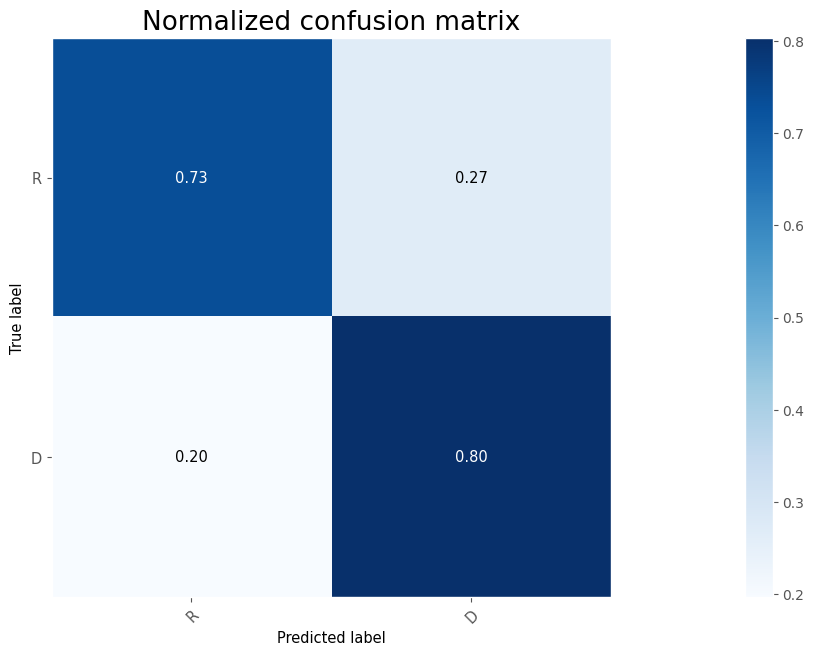

In [27]:
# Get prediction form model on validation data. This is where you should use
# your test data.
true_labels, predictions_labels, avg_epoch_loss, speakers = validation(valid_dataloader, device)

# Create the evaluation report.
evaluation_report = classification_report(true_labels, predictions_labels, labels=list(labels_ids.values()), target_names=list(labels_ids.keys()))
# Show the evaluation report.
print(evaluation_report)

# Plot confusion matrix.
plot_confusion_matrix(y_true=true_labels, y_pred=predictions_labels, 
                      classes=list(labels_ids.keys()), normalize=True, 
                      magnify=0.1,
                      );

In [28]:
confused_speakers = {}
number_of_speeches = {}

for i in range(0, len(true_labels)):
    speaker = speakers[i]
    if speaker not in confused_speakers:
        confused_speakers[speaker] = 0
        number_of_speeches[speaker] = 0
    
    if predictions_labels[i] != true_labels[i]:
        confused_speakers[speaker] += 1
    
    number_of_speeches[speaker] += 1

normalized_confused_speakers = {name:(confusions / (number_of_speeches[name] * 1.0)) for name, confusions in confused_speakers.items()}
normalized_confused_speakers = dict(sorted(normalized_confused_speakers.items(), key=lambda item: item[1], reverse=True))
print(normalized_confused_speakers)

{'D_JIM_COOPER_TN_119040': 0.7692307692307693, 'R_CHRIS_COLLINS_NY_122460': 0.7272727272727273, 'R_TIM_MURPHY_PA_120610': 0.7115384615384616, 'D_RICK_LARSEN_WA_120150': 0.7058823529411765, 'R_WALTER_JONES_NC_119990': 0.65625, 'R_RICHARD_HANNA_NY_119680': 0.65, 'R_KAY_GRANGER_TX_119580': 0.6363636363636364, 'D_PETER_VISCLOSKY_IN_121640': 0.6210526315789474, 'R_CHRISTOPHER_GIBSON_NY_119530': 0.575, 'R_CURTIS_CLAWSON_FL_122750': 0.5625, 'R_ELISE_STEFANIK_NY_123200': 0.5428571428571428, 'R_FRENCH_HILL_AR_122820': 0.5365853658536586, 'R_JEFF_FORTENBERRY_NE_119440': 0.5348837209302325, 'R_ROBERT_HURT_VA_119880': 0.5283018867924528, 'D_COLLIN_PETERSON_MN_120810': 0.5238095238095238, 'D_ADAM_SMITH_WA_121420': 0.52, 'R_MICK_MULVANEY_SC_120580': 0.5052631578947369, 'D_CHAKA_FATTAH_PA_118070': 0.5034013605442177, 'R_FRANK_LOBIONDO_NJ_120240': 0.5, 'R_DARRELL_ISSA_CA_119910': 0.5, 'R_JIM_JORDAN_OH_120000': 0.5, 'R_SUSAN_COLLINS_ME_118301': 0.48828125, 'D_BRAD_ASHFORD_NE_123140': 0.4878048780487805

Democrat Pearson Value: PearsonRResult(statistic=0.30454146183192415, pvalue=2.0385561987064583e-05)
Republican Pearson Value: PearsonRResult(statistic=-0.17550765010316663, pvalue=0.005777191565409815)


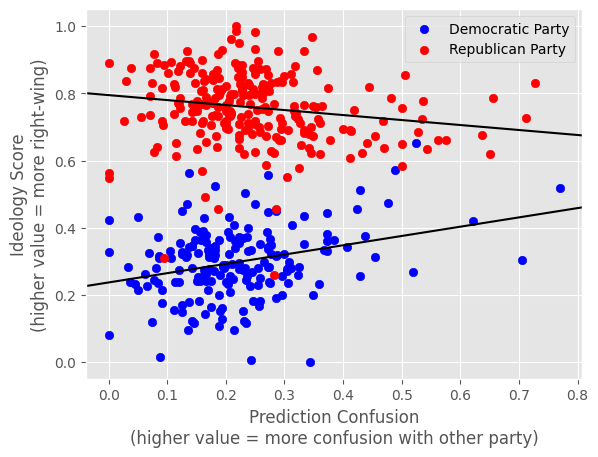

In [29]:
import csv
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as mp

def generate_confusion_and_ideology_arrays(party):
    ideology_ratings = {}
    
    with open('../data/govtrack-stats-2016-house-ideology.csv') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)

        for row in reader:
            key = f'{row[8][2:-1]}_{row[6]}'.upper()
            ideology_ratings[key] = float(row[3])
    
    '''with open('../data/govtrack-stats-2014-house-ideology.csv') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)

        for row in reader:
            key = f'{row[8][2:-1]}_{row[6]}'.upper()
            ideology_ratings[key] = float(row[3])'''

    ordered_confusions = []
    ordered_ideologies = []

    for confused_speaker_name, confused_speaker_confusion in normalized_confused_speakers.items():
        for ideology_speaker_name, ideology_speaker_rating in ideology_ratings.items():
            if ideology_speaker_name in confused_speaker_name and confused_speaker_name.startswith(party):
                ordered_confusions.append(confused_speaker_confusion)
                ordered_ideologies.append(ideology_speaker_rating)
    
    return ordered_confusions, ordered_ideologies

d_confusions, d_ideologies = generate_confusion_and_ideology_arrays(party='D')
print(f'Democrat Pearson Value: {pearsonr(d_confusions, d_ideologies)}')

mp.scatter(d_confusions, d_ideologies, color='blue', label='Democratic Party')

m, b = np.polyfit(d_confusions, d_ideologies, deg=1)
mp.axline(xy1=(0, b), slope=m, label='_nolegend_', color='black')

r_confusions, r_ideologies = generate_confusion_and_ideology_arrays(party='R')
print(f'Republican Pearson Value: {pearsonr(r_confusions, r_ideologies)}')

mp.scatter(r_confusions, r_ideologies, color='red', label='Republican Party')

m2, b2 = np.polyfit(r_confusions, r_ideologies, deg=1)
mp.axline(xy1=(0, b2), slope=m2, label='_nolegend_', color='black')

mp.rc('axes', labelsize=10)
mp.xlabel('Prediction Confusion\n(higher value = more confusion with other party)')
mp.ylabel('Ideology Score\n(higher value = more right-wing)')
mp.legend()
mp.show()